In [0]:
# Imports 
import glob, os
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display


In [0]:
! git clone https://github.com/tyiannak/pyAudioAnalysis.git

[source article](https://walczak.org/2019/02/automatic-splitting-audio-files-silence-python/)

[source github](https://github.com/tyiannak/pyAudioAnalysis)

In [0]:
# Install the requirements from the Audio Analysis Paper 
! pip install -r /content/pyAudioAnalysis/requirements.txt

In [26]:
# Mount the Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Unzip the audio files 

!unzip  <FILE-PATH>

In [0]:
# Convert to spectrograms
def get_spec_info():
  src_dir = "/content/" # source directory path
  sample_rate_list = []
  samples_list = []
  frequencies_list = []
  times_list = []
  spectrogram_list = []
  x_list = []
  sr_list = []


  counter = 0
  for file in sorted(glob.glob(f"{src_dir}/*.wav")):
    counter += 1
    print('Making spectrogram for file: ' , counter)
    sample_rate, samples = wavfile.read(file)
    x, sr = librosa.load(file, sr=sample_rate)
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

    sample_rate_list.append(sample_rate)
    samples_list.append(samples)
    frequencies_list.append(frequencies)
    times_list.append(times)
    spectrogram_list.append(spectrogram)
    x_list.append(x)
    sr_list.append(sr)
      
  return sample_rate_list , samples_list , frequencies_list , times_list , spectrogram_list , x_list , sr_list

In [0]:
sample_rate_list , samples_list , frequencies_list , times_list , spectrogram_list , x_list , sr_list = get_spec_info()

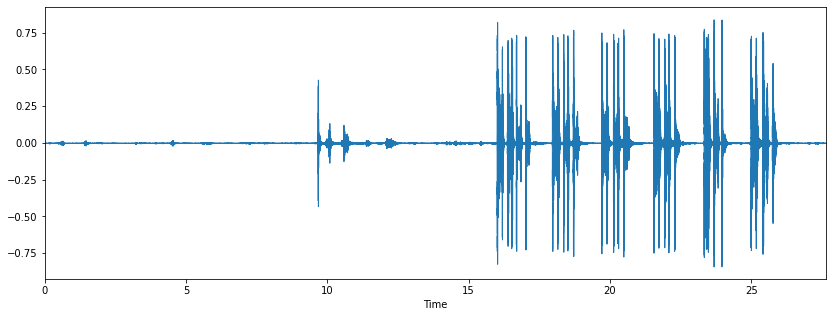

In [30]:
#plt.pcolormesh(times_list[79], frequencies_list[79], spectrogram_list[79])
#plt.ylim(0,4000)

# Plot one of the coughs before removing silence
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x_list[0], sr=sr_list[0])

In [0]:
# Remove silences in the cough files 
# TO DO: This is not working... the audio still has silence in it!
src_dir = "/content/" # source directory path
for file in sorted(glob.glob(f"{src_dir}/*.wav")):
    print("#"*40)
    print(file)
    src_code = "/content/pyAudioAnalysis/pyAudioAnalysis/audioAnalysis.py" # running using the sourcecode 
    os.system(f"python {src_code} silenceRemoval -i " + file + " --smoothing 0.2 --weight 0.1")

In [0]:
sample_rate_list , samples_list , frequencies_list , times_list , spectrogram_list , x_list , sr_list = get_spec_info()

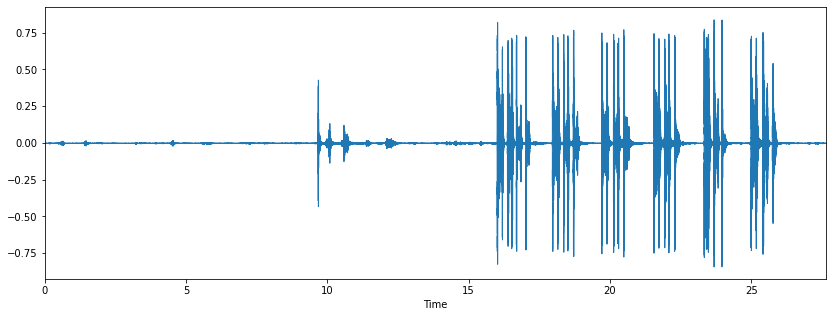

In [33]:

#TO DO: Figure out how to remove the silences from the file itself
plt.figure(figsize=(14, 5))
#librosa.display.waveplot(x_list[0], sr=sr_list[0])

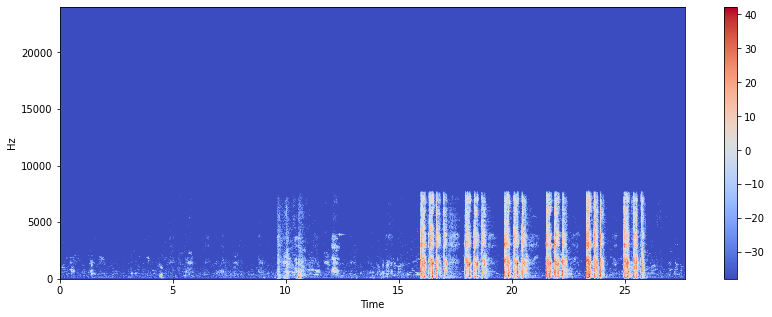

In [34]:
# Plot the spectrogram

X = librosa.stft(x_list[0])
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()


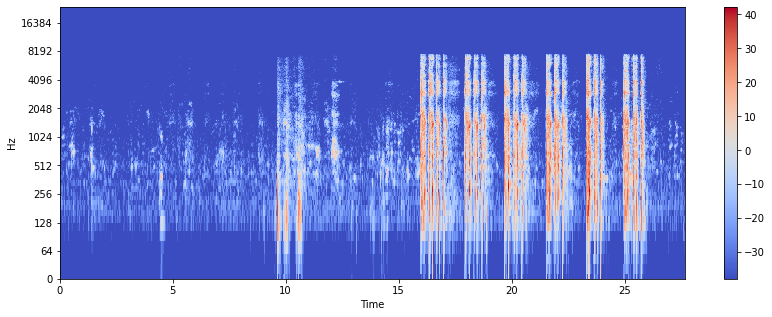

In [36]:
# Log Transform the Spectrogram

plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

In [0]:
# TO DO

# - Map each spectrogram to the appropriate label
# - Remove silences
# - Extract features such as pitch, tempo, etc
# - Store features into the appropriate data structure

